In [ ]:
# This was my try, I wanted to understand that, Is there any possibility of stocks that follows the paths that we eventually see in the sales pattern.
# Random walk theory is so true. The core thinking behimd this is only find if there is any co relation of prices.
# It may be possible that, If we consider many factors into consideration then it may possible to draw some outcome out of it.
# It will be long way but long story in short we may try to understand volatility, volume and create something in a way which helps us in live market. 
# One may know when to sell and where to hold. Assuming that if we set some volatility measure and normalize the prices in a way which gaves some patterns but it is riskier. 
# For learning purpose and curiosity, Let's try it. 

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Plot style
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.grid"] = True

In [20]:
symbol = "RELIANCE.NS"   # Reliance Industries on NSE (Yahoo Finance ticker)
interval = "30m"         # 30-minute time frame
lookback_period = "60d"  # last 60 calendar days (enough to get several Fridays)

data = yf.download(
    tickers=symbol,
    period=lookback_period,
    interval=interval,
    auto_adjust=True,     # adjust for splits/dividends
    progress=False
)

if data.empty:
    raise ValueError("No data downloaded. Try another symbol or change period/interval.")

# We expect columns like: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
print("Downloaded columns:", data.columns.tolist())

# Keep only Close price for this project
if "Close" not in data.columns:
    raise ValueError("Expected 'Close' column not found in downloaded data.")

df = data[["Close"]].copy()

# Add date and time columns based on index (which is a DatetimeIndex)
df["date"] = df.index.date        # e.g. 2025-12-05
df["time"] = df.index.time        # e.g. 10:15:00



Downloaded columns: [('Close', 'RELIANCE.NS'), ('High', 'RELIANCE.NS'), ('Low', 'RELIANCE.NS'), ('Open', 'RELIANCE.NS'), ('Volume', 'RELIANCE.NS')]


In [21]:
data.head(5)

Price,Close,High,Low,Open,Volume
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS
Datetime,,,,,
2025-09-11 04:00:00+00:00,1381.699951,1382.500000,1379.599976,1380.699951,328785
2025-09-11 04:30:00+00:00,1382.199951,1383.000000,1380.000000,1381.900024,286968
2025-09-11 05:00:00+00:00,1383.900024,1384.599976,1381.900024,1382.199951,498335
2025-09-11 05:30:00+00:00,1383.900024,1385.300049,1382.800049,1383.500000,482319
2025-09-11 06:00:00+00:00,1382.500000,1384.699951,1382.000000,1383.900024,437484


In [22]:
data.tail(5)

Price,Close,High,Low,Open,Volume
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS
Datetime,,,,,
2025-12-05 07:30:00+00:00,1539.199951,1540.400024,1536.900024,1537.500000,445269
2025-12-05 08:00:00+00:00,1537.000000,1540.900024,1536.500000,1539.199951,472303
2025-12-05 08:30:00+00:00,1537.000000,1538.500000,1535.900024,1537.099976,566373
2025-12-05 09:00:00+00:00,1536.300049,1538.400024,1534.400024,1537.000000,579864
2025-12-05 09:30:00+00:00,1544.599976,1545.500000,1535.800049,1536.000000,3524038


Target Friday:     2025-12-05
Yesterday Thursday: 2025-12-04
L3W Fridays used:  [datetime.date(2025, 11, 14), datetime.date(2025, 11, 21), datetime.date(2025, 11, 28)]
Merged columns: [('time', ''), ('friday_close', 'RELIANCE.NS'), ('thursday_close', 'RELIANCE.NS'), ('L3W_avg_close', 'RELIANCE.NS')]
Price       time friday_close thursday_close L3W_avg_close
Ticker            RELIANCE.NS    RELIANCE.NS   RELIANCE.NS
0       04:00:00  1523.000000    1548.599976   1547.266683
1       04:30:00  1525.500000    1553.199951   1546.133341
2       05:00:00  1531.500000    1557.699951   1546.899984
3       05:30:00  1533.099976    1557.199951   1544.633301
4       06:00:00  1533.000000    1552.099976   1543.099976


C:\Users\abhay\AppData\Local\Temp\ipykernel_17924\2151342247.py:48: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  merged = friday_times.merge(thursday_times, on="time", how="left")
C:\Users\abhay\AppData\Local\Temp\ipykernel_17924\2151342247.py:50: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  merged = merged.merge(l3w_avg, on="time", how="left")


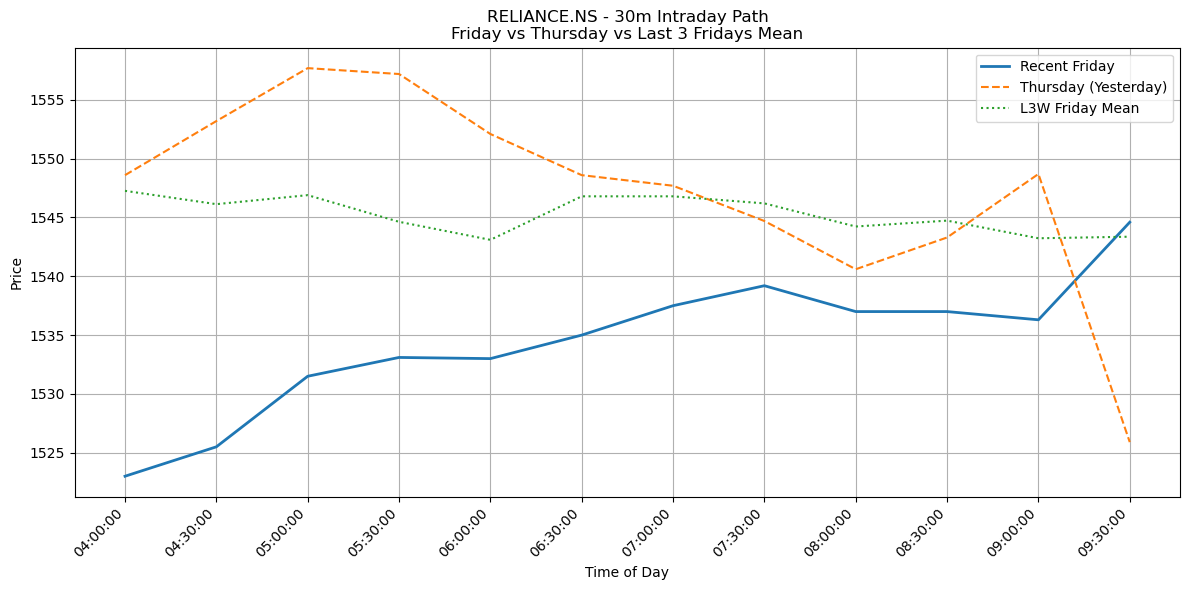

In [23]:
trading_days = sorted(df["date"].unique())

friday_days = [d for d in trading_days if pd.Timestamp(d).weekday() == 4]

if len(friday_days) == 0:
    raise ValueError("No Friday found in the data. Increase lookback_period.")

target_friday = friday_days[-1]

thursday_candidates = [
    d for d in trading_days
    if d < target_friday and pd.Timestamp(d).weekday() == 3
]

if len(thursday_candidates) == 0:
    raise ValueError("No Thursday found before the target Friday in the data.")

target_thursday = thursday_candidates[-1]

prior_fridays = [d for d in friday_days if d < target_friday]
if len(prior_fridays) == 0:
    raise ValueError("No prior Fridays found for L3W computation.")

l3w_fridays = prior_fridays[-3:] if len(prior_fridays) >= 3 else prior_fridays

print(f"Target Friday:     {target_friday}")
print(f"Yesterday Thursday: {target_thursday}")
print(f"L3W Fridays used:  {l3w_fridays}")

df_friday = df[df["date"] == target_friday].copy()

df_thursday = df[df["date"] == target_thursday].copy()

df_l3w = df[df["date"].isin(l3w_fridays)].copy()

l3w_avg = (
    df_l3w
    .groupby("time", as_index=False)["Close"]
    .mean()
)

l3w_avg.rename(columns={"Close": "L3W_avg_close"}, inplace=True)

friday_times = df_friday[["time", "Close"]].rename(columns={"Close": "friday_close"})

thursday_times = df_thursday[["time", "Close"]].rename(columns={"Close": "thursday_close"})

merged = friday_times.merge(thursday_times, on="time", how="left")

merged = merged.merge(l3w_avg, on="time", how="left")

merged.sort_values("time", inplace=True)

print("Merged columns:", merged.columns.tolist())
print(merged.head())

fig, ax = plt.subplots()

x = merged["time"].astype(str)

ax.plot(x, merged["friday_close"],   label="Recent Friday",   linewidth=2)
ax.plot(x, merged["thursday_close"], label="Thursday (Yesterday)", linestyle="--")
ax.plot(x, merged["L3W_avg_close"],  label="L3W Friday Mean", linestyle=":")

ax.set_title(f"{symbol} - 30m Intraday Path\nFriday vs Thursday vs Last 3 Fridays Mean")
ax.set_xlabel("Time of Day")
ax.set_ylabel("Price")
ax.legend()

step = max(1, len(x) // 10)  # show ~10 labels
ax.set_xticks(x[::step])
ax.set_xticklabels(x[::step], rotation=45, ha="right")

plt.tight_layout()
plt.show()